# Final QOI overview

**Author:** Hannu Parviainen </br>
**Edited:** 26.5.2022

Here we take a look at the final quantities of interest (QOIs) from the joint modelling.

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import arviz as az
import pandas as pd

from pathlib import Path
from astropy import units as u

from src.kelt1 import filters, filter_names, read_mcmc, round_with_uncertainty, derive_qois,  star_rho, rv_k

pb_names = r"\cheops, \tess, \pbh, \pbks, \spitzer 3.6~$\mu$m, \spitzer 4.5~$\mu$m".split(', ')
pbn = 'CHEOPS, TESS, H, Ks, 3.6 $\mu$m, 4.5 $\mu$m'.split(', ')

In [4]:
df = derive_qois(read_mcmc('results/03b_fin_emission_and_constrained_ev.nc'))

## Nightside planet-star flux ratios 

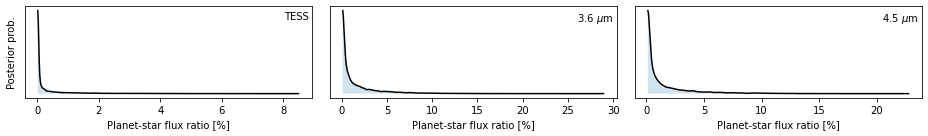

In [10]:
cs = [c for c in df.columns if c[:3] == 'ten']
fig, axs = subplots(1, 3, figsize=(13, 2), sharey='all')
for i,j in enumerate((1,4,5)):
    c = cs[j]
    x, y = az.kde(1e2*df[c])
    y /= y.max()
    ax = axs.flat[i]
    ax.fill_between(x, y, alpha=0.2)
    ax.plot(x, y, 'k')
    ax.text(0.99, 0.95, pbn[j], transform=ax.transAxes, ha='right', va='top')
setp(axs[0], ylabel='Posterior prob.')
setp(axs, yticks=[], xlabel='Planet-star flux ratio [%]')
fig.tight_layout()

In [13]:
for pb in ('TESS', '36um', '45um'):
    upper_limit = percentile(1e2*df[f'ten_{pb}'], 99)
    print(f"{pb} f_n < {round(upper_limit, 1)}")

TESS f_n < 4.6
36um f_n < 13.8
45um f_n < 12.0


## Dayside flux ratios and eclipse depths

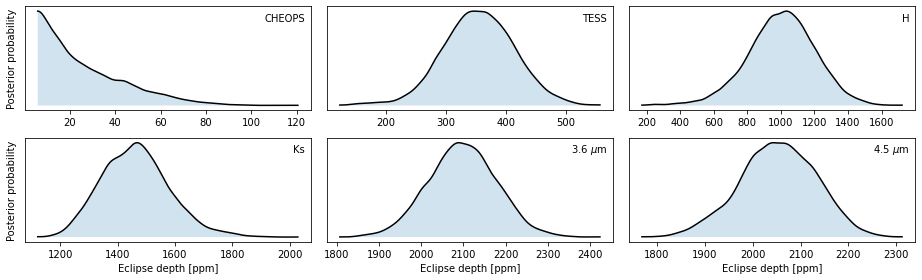

In [17]:
cs = [c for c in df.columns if c[:3] == 'ted']
fig, axs = subplots(2, 3, figsize=(13,4), sharey='all')
for i, c in enumerate(cs):
    x, y = az.kde(1e6*df.k2*df[c])
    y /= y.max()
    ax = axs.flat[i]
    ax.fill_between(x, y, alpha=0.2)
    ax.plot(x, y, 'k')
    ax.text(0.98, 0.86, pbn[i], ha='right', transform=ax.transAxes)
setp(axs[:, 0], ylabel='Posterior probability', yticks=[])
setp(axs[-1], xlabel='Eclipse depth [ppm]')
fig.tight_layout()

In [18]:
print('Dayside flux ratios and eclipse depths')
print('--------------------------------------')
for i,pb in enumerate(filter_names):
    pfr = percentile(1e2*df[f'ted_{pb}'], [50, 16, 84, 99])
    ped = percentile(1e6*df.k2*df[f'ted_{pb}'], [50, 16, 84, 99])
    frm, fre, fru = map(lambda a: round(a, 3), (pfr[0], abs(pfr[1:3]-pfr[0]).mean(), pfr[3]))
    edm, ede, edu = map(lambda a: round(a, 1), (ped[0], abs(ped[1:3]-ped[0]).mean(), ped[3]))
    print(f"{pb_names[i]:20} & ${frm:6} \\pm {fre:5} < {fru:6}$ & ${edm:7} \\pm {ede:5} < {edu:7} $\\\\")

Dayside flux ratios and eclipse depths
--------------------------------------
\cheops              & $ 0.376 \pm 0.315 <  1.401$ & $   21.9 \pm  18.4 <    81.7 $\\
\tess                & $ 6.094 \pm 0.997 <  8.477$ & $  355.1 \pm  58.1 <   492.5 $\\
\pbh                 & $17.344 \pm 3.327 < 24.862$ & $ 1010.6 \pm 193.5 <  1454.8 $\\
\pbks                & $25.022 \pm 2.045 < 30.625$ & $ 1458.7 \pm 116.2 <  1782.3 $\\
\spitzer 3.6~$\mu$m  & $36.006 \pm 1.454 <  39.54$ & $ 2096.9 \pm  81.7 <  2288.7 $\\
\spitzer 4.5~$\mu$m  & $35.229 \pm 1.484 < 38.568$ & $ 2054.0 \pm  79.2 <  2226.0 $\\


In [19]:
print('Dayside flux ratios and eclipse depths')
print('--------------------------------------')
for i,pb in enumerate(filter_names):
    ped = percentile(1e6*df.k2*df[f'ted_{pb}'], [50, 16, 84, 99])
    edm, ede, edu = map(lambda a: round(a, 1), (ped[0], abs(ped[1:3]-ped[0]).mean(), ped[3]))
    print(f"{filter_names[i]:20} {edm:7} +- {ede:5}")

Dayside flux ratios and eclipse depths
--------------------------------------
CHEOPS                  21.9 +-  18.4
TESS                   355.1 +-  58.1
H                     1010.6 +- 193.5
Ks                    1458.7 +- 116.2
36um                  2096.9 +-  81.7
45um                  2054.0 +-  79.2


## Rest of the QOIs

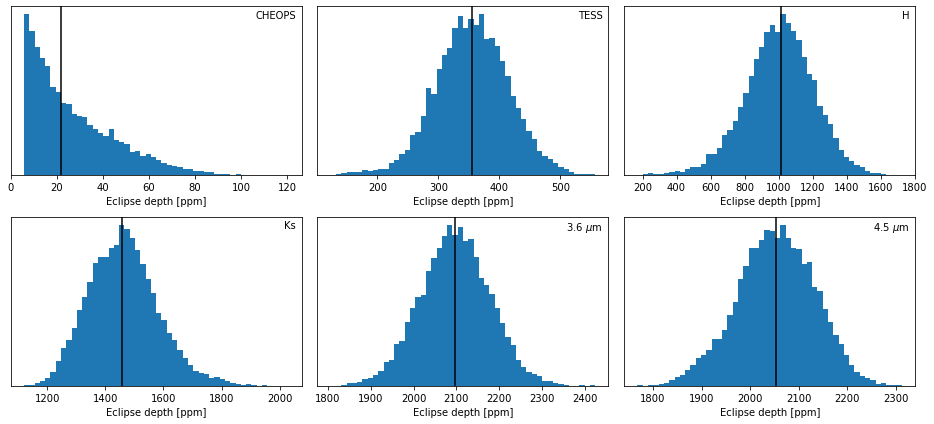

In [21]:
fig, axs = subplots(2, 3, figsize=(13, 6))
for i,pb in enumerate(filter_names):
    ax = axs.flat[i]
    ed = 1e6*df.k2*df[f'ted_{pb}']
    ax.hist(ed, bins=50)
    ax.axvline(median(ed), c='k')
    ax.text(0.98, 0.98, pbn[i], transform=ax.transAxes, va='top', ha='right')
setp(axs, yticks=[], xlabel='Eclipse depth [ppm]')
fig.tight_layout()

In [22]:
ns = df.shape[0]
period = (df.p.values*u.d).to(u.s)
k = (normal(rv_k.n, rv_k.s, ns) * u.m / u.s).to(u.cm/u.s)
g_planet = (2*pi)/period * k / ((df.k.values / df.a.values)**2 * sin(df.inc.values))
df['logg_p'] = log10(g_planet.value)

In [23]:
pars = 'tc p t14 - k a b - mp - r a_au teq rho inc_deg logg_p'.split()

for par in pars:
    if par == '-':
        print()
    else:
        p = percentile(df[par], [50, 16, 84])
        pm, pem, pep = round_with_uncertainty(p[0], p[1]-p[0], p[2]-p[0])
        print(f"{par:8} {pm} ({pem}) ({pep})", p[0])

tc       2455914.16237 (-0.00038) (0.00036) 2455914.1623702734
p        1.21749422 (-1.9e-07) (1.9e-07) 1.2174942221943073
t14      2.736 (-0.015) (0.015) 2.7356245268347728

k        0.07632 (-0.00046) (0.0005) 0.07632354512013972
a        3.54 (-0.089) (0.09) 3.5396982178518934
b        0.34 (-0.084) (0.064) 0.33982122306380785

mp       27.6 (-0.88) (0.85) 27.603969388834912

r        1.1363 (-0.0095) (0.0099) 1.1363121467478476
a_au     0.02518 (-0.00065) (0.00067) 0.02517866986936782
teq      2550.0 (-170.0) (170.0) 2549.785548994034
rho      0.566 (-0.041) (0.045) 0.5659823610354916
inc_deg  84.5 (-1.2) (1.5) 84.49188476338756
logg_p   4.738 (-0.026) (0.025) 4.738167389628119


---

<center>&copy;2022 Hannu Parviainen</center>